## Analyzing the enviromental conditions of New York City neighborhoods using low cost sensors and open data 

#### The goal of this notebook is to analyize the sensor data from the Redhook Initative - CUSP. WIt this aim, we will combine the sensor data with other Open Data such as NYC Building data and Weather

#### The sensor data dataset used contains the sensor data for luminosity (in Lux), particulate concentration (particle count per 0.01 cubic feet), and noise (sound pressure level in dB). The dataset includes readings for four (4) sensors in Red Hook from June 2016.

### Dependencies:
#### This notebook has two types of dependencies: data files and API keys. Both should be fulfilled in order to re run the notebook.The Data files are also commited to the repository, on the /Data directory. Clonning the entire repository will take care of it. The API keys need to be requested for each of the service dependencies. Details about the services can be found on the Markup cells.

In [1]:
# Standard imports wo wotk with data, graphs, APIs, etc.

# Compatibility with Python 3
from __future__ import print_function, division

import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO
# from get_jsonparsed_data import get_jsonparsed_data
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
# update the rcParams object
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['griddata', 'insert', 'polyint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [462]:
# Aditional Imports
import pyowm
import calendar
import json
import pickle
from datetime import date, timedelta
from shapely.geometry import Point


In [3]:
# Helper function to use the Google geocode API
# Developed by sbania for this notebook

def getAddressLatLon(address):
    '''
    This function returns the lat and lon of a given address
    retreived from the google geocode API
    if the address is amibiguous it throws an exception
    '''
    APIurl = "http://maps.google.com/maps/api/geocode/json?address=" +\
    urllib.quote_plus(address)
    #Get the response and load the string representation into a tuple
    #print (APIurl)
    response = urllib2.urlopen(APIurl)
    geodataString = response.read().decode("utf-8")
    geodata = json.loads(geodataString)
    if len(geodata['results'])>1:
        raise Exception("The address is ambiguous, try a better one!")
    else:
        location = geodata['results'][0]['geometry']['location']
    return location

In [4]:
getAddressLatLon("767 Hicks St, Brooklyn, NY")

{u'lat': 40.67677949999999, u'lng': -74.0044647}

In [5]:
# Helper functions to save and load objects using pickle
# Function forked and modified from Stack Overflow response
# http://stackoverflow.com/users/1222923/gonzalo-cao

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
# Helper function to query CartoDB using the SQL API
# Function from fedhere reference notebook
# https://github.com/fedhere/PUI2016_fb55/blob/master/HW12_fb55/Assignment%201%20instructions.ipynb

def queryCartoDB(query, format, source):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

## Section I: Data Wrangling

### I a) Loading the datasets from sources
##### Create the adequate Python structures to load and manipulate the seonsor data

In [103]:
# Load the data from the CSV file on the data directory

filePath = "data/LuxDustNoise_summarized_4hour_0719.csv"
dfSensorData = pd.read_csv(filePath)

# Rearrange the data into a dictionary of Dataframes (one per sensor)
sensors = {}
    
for sensorId in dfSensorData.sensor.unique():
    sensors[sensorId] = {}
    sensors[sensorId]['data'] = dfSensorData[dfSensorData.sensor==sensorId]
    
    #Convert string to timestamp
    sensors[sensorId]['data']['dt'] =  pd.to_datetime(sensors[sensorId]['data'].dt
                                              , format='%Y-%m-%d %H:%M:%S')

# Add the address of the sensors to the dictionary
sensors['sensor_0']['address'] = "767 Hicks St, Brooklyn, NY"
sensors['sensor_2']['address'] = "767 Hicks St, Brooklyn, NY"
sensors['sensor_3']['address'] = "106 Ferris St, Brooklyn, NY"
sensors['sensor_4']['address'] = "159 Pioneer St, Brooklyn, NY"

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
# Use the getAddressLatLon helper function to get the coordinates
# of the sensors (these will be used later for calling the openweatherAPI)

for key, value in sensors.iteritems():
    sensors[key]['latlon'] = getAddressLatLon(sensors[key]['address'])

In [105]:
# Display the sensors name, address and location

for key, value in sensors.iteritems():
    print(key + " is located in " + sensors[key]['address'] +\
          " (" + str(sensors[key]['latlon']) + ")")

sensor_3 is located in 106 Ferris St, Brooklyn, NY ({u'lat': 40.677963, u'lng': -74.01766099999999})
sensor_2 is located in 767 Hicks St, Brooklyn, NY ({u'lat': 40.67677949999999, u'lng': -74.0044647})
sensor_0 is located in 767 Hicks St, Brooklyn, NY ({u'lat': 40.67677949999999, u'lng': -74.0044647})
sensor_4 is located in 159 Pioneer St, Brooklyn, NY ({u'lat': 40.67920429999999, u'lng': -74.0121745})


In [107]:
# Create a list with the dates
# for which there is sensor data

d1 = sensors['sensor_0']['data'].dt.min()
d2 = sensors['sensor_0']['data'].dt.max()
delta = d2 - d1

sensorDates = []

for i in range(delta.days + 1):
    sensorDates.append(d1 + timedelta(days=i))

In [108]:
# Check how the dataset looks
sensors['sensor_0']['data'].head()

,dt,sensor,lux,con,spl
0,2016-06-21 00:00:00,sensor_0,0.000,2834.03125,66.308479
4,2016-06-21 04:00:00,sensor_0,3213.500,2748.28875,81.467436
8,2016-06-21 08:00:00,sensor_0,24532.625,2720.35125,80.020600
12,2016-06-21 12:00:00,sensor_0,40268.250,2443.72875,76.525876
16,2016-06-21 16:00:00,sensor_0,17189.750,2717.49625,80.020600


### I b) Visual Inspection of the Dataset:
##### Plotting all the sensors data to visually identify trends, periods and outliers. This initial inspection will guide the later more rigurous inspection and types of analysis

In [109]:
#Visualize the location of the sensors



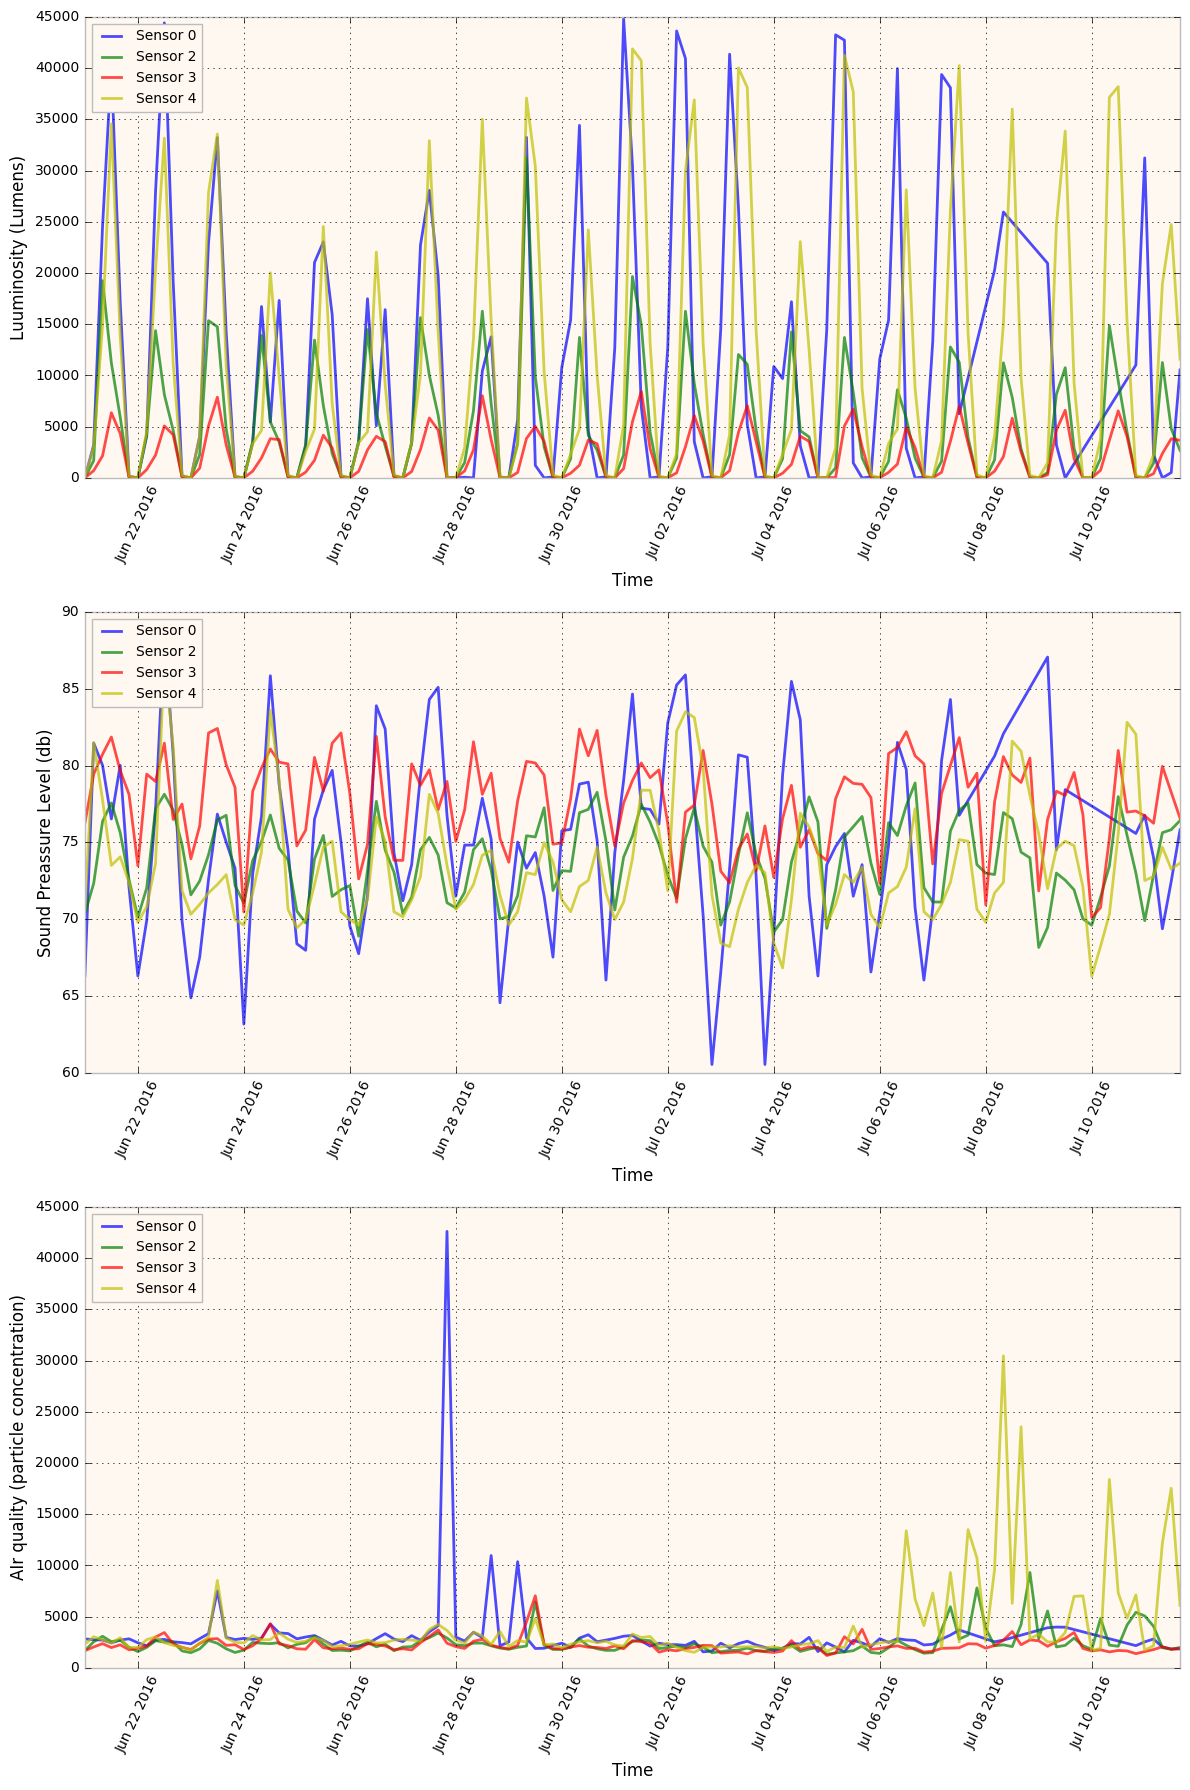

In [110]:
# Visualize the Lux, spl and con from the sensors

pl.figure(figsize=(12, 18))

# Plot A single sensor data
pl.subplot(3, 1, 1)
pl.xlabel("Time")
pl.ylabel("Luuminosity (Lumens)") 
pl.plot(sensors['sensor_0']['data'].dt, sensors['sensor_0']['data'].lux,'b', alpha=0.7, 
        label="Sensor 0")
pl.plot(sensors['sensor_2']['data'].dt, sensors['sensor_2']['data'].lux,'g', alpha=0.7,
        label="Sensor 2")
pl.plot(sensors['sensor_3']['data'].dt, sensors['sensor_3']['data'].lux,'r', alpha=0.7,
       label="Sensor 3")
pl.plot(sensors['sensor_4']['data'].dt, sensors['sensor_4']['data'].lux,'y', alpha=0.7,
       label="Sensor 4")
pl.xticks(rotation='65')
pl.legend(loc='upper left')

#figtext(0.1,-.1,"Figure I: Luminosity as captured by sensor")

pl.subplot(3, 1, 2)
pl.xlabel("Time")
pl.ylabel("Sound Preassure Level (db)") 
pl.plot(sensors['sensor_0']['data'].dt, sensors['sensor_0']['data'].spl,'b', alpha=0.7, 
        label="Sensor 0")
pl.plot(sensors['sensor_2']['data'].dt, sensors['sensor_2']['data'].spl,'g', alpha=0.7,
        label="Sensor 2")
pl.plot(sensors['sensor_3']['data'].dt, sensors['sensor_3']['data'].spl,'r', alpha=0.7,
       label="Sensor 3")
pl.plot(sensors['sensor_4']['data'].dt, sensors['sensor_4']['data'].spl,'y', alpha=0.7,
       label="Sensor 4")
pl.xticks(rotation='65')
pl.legend(loc='upper left')

pl.subplot(3, 1, 3)
pl.xlabel("Time")
pl.ylabel("AIr quality (particle concentration)") 
pl.plot(sensors['sensor_0']['data'].dt, sensors['sensor_0']['data'].con,'b', alpha=0.7, 
        label="Sensor 0")
pl.plot(sensors['sensor_2']['data'].dt, sensors['sensor_2']['data'].con,'g', alpha=0.7,
        label="Sensor 2")
pl.plot(sensors['sensor_3']['data'].dt, sensors['sensor_3']['data'].con,'r', alpha=0.7,
       label="Sensor 3")
pl.plot(sensors['sensor_4']['data'].dt, sensors['sensor_4']['data'].con,'y', alpha=0.7,
       label="Sensor 4")
pl.xticks(rotation='65')
pl.legend(loc='upper left')

pl.tight_layout()

(array([ 736137.,  736139.,  736141.,  736143.,  736145.,  736147.,
         736149.,  736151.,  736153.,  736155.]),
 <a list of 10 Text xticklabel objects>)

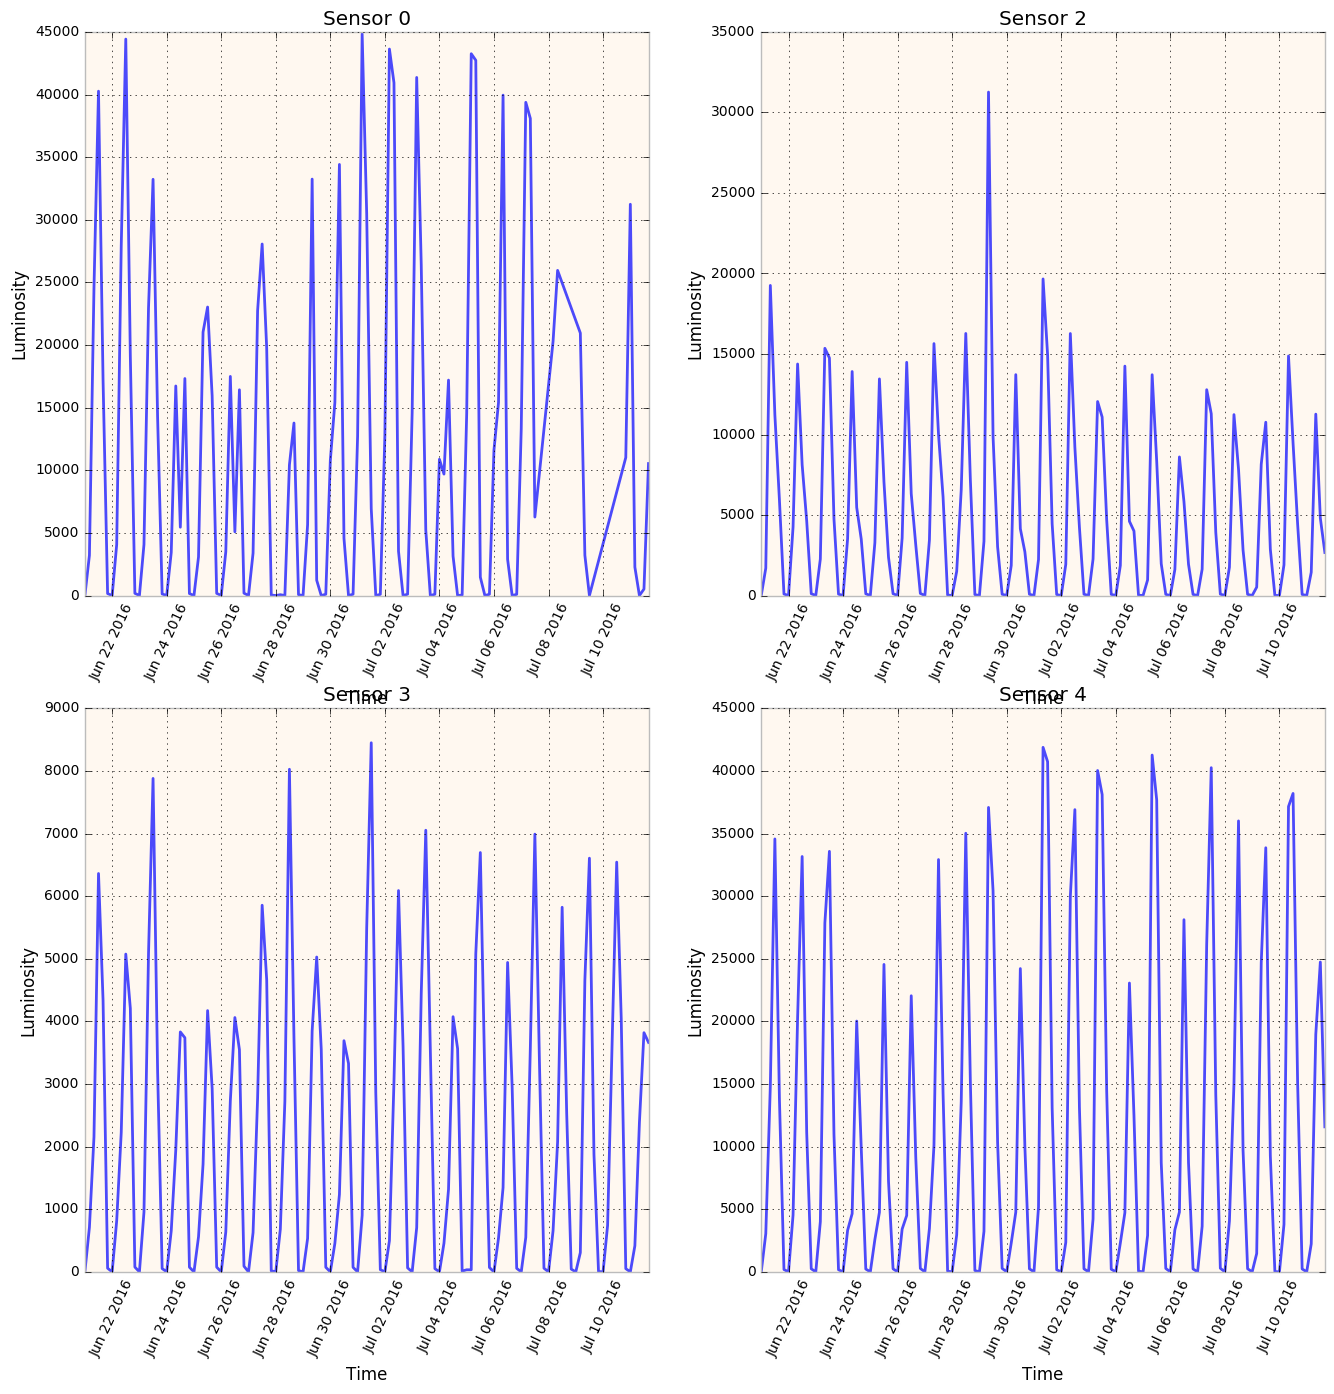

In [111]:
# Plot the individual meassures for each of the sensors

pl.figure(figsize=(16, 16))

# Sensor 0
pl.subplot(2, 2, 1)
pl.plot(sensors['sensor_0']['data'].dt, sensors['sensor_0']['data'].lux,'b', alpha=0.7)
pl.xlabel('Time\n')
pl.ylabel('Luminosity')
pl.title('Sensor 0')
pl.xticks(rotation='65')

# Sensor 1
pl.subplot(2, 2, 2)
pl.plot(sensors['sensor_2']['data'].dt, sensors['sensor_2']['data'].lux,'b', alpha=0.7)
pl.xlabel('Time\n')
pl.ylabel('Luminosity')
pl.title('Sensor 2')
pl.xticks(rotation='65')

# Sensor 2
pl.subplot(2, 2, 3)
pl.plot(sensors['sensor_3']['data'].dt, sensors['sensor_3']['data'].lux,'b', alpha=0.7)
pl.xlabel('Time')
pl.ylabel('Luminosity')
pl.title('Sensor 3')
pl.xticks(rotation='65')
              
# Sensor 3
pl.subplot(2, 2, 4)
pl.plot(sensors['sensor_4']['data'].dt, sensors['sensor_4']['data'].lux,'b', alpha=0.7)
pl.xlabel('Time')
pl.ylabel('Luminosity')
pl.title('Sensor 4')
pl.xticks(rotation='65')


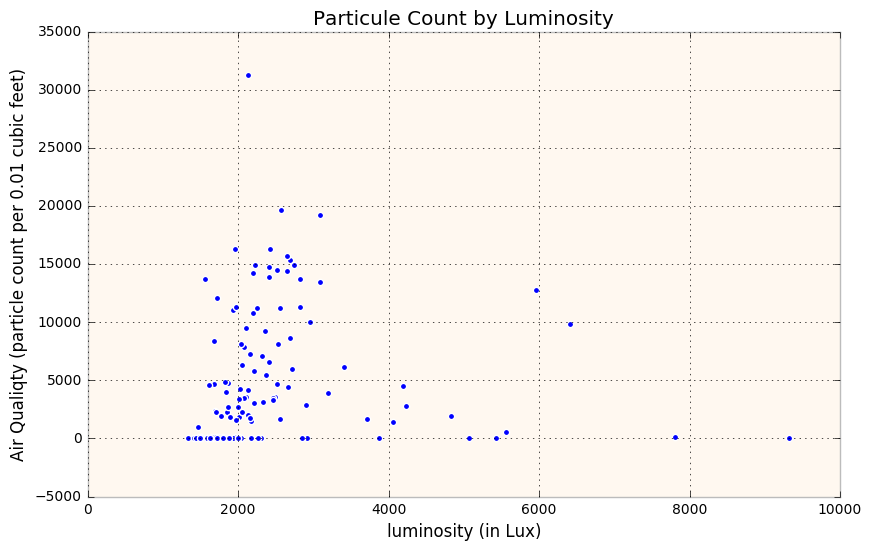

In [112]:
pl.figure(figsize=(6 * 1.618, 6))
pl.ylabel("Air Qualiqty (particle count per 0.01 cubic feet)")
pl.xlabel("luminosity (in Lux)")
pl.scatter(sensors['sensor_2']['data'].con,sensors['sensor_2']['data'].lux)
pl.title('Particule Count by Luminosity')

### I. c) Augmenting the datasets:
##### Draw information from aditional datasets in order to bring aditional elements for the analysis

##### Historic Weather Data

We decided to complement the sensor data with historic weather data in order to try to establish correlations between the environmental conditions and the weather.

We tried to use the closest NOAA weather station, but unfortunately
It only contained data on the Precipitations (No Temperature, Humidity, etc.)
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:US1NYKN0025/detail

After reviewing the different non public weather services that expose APIs, we decided to use the weather underground API, which allowed a free tier ussage. The API presents an easy to use RESTFull API, but the available documentation (sepcially the field descriptions was not very complete)

https://www.wunderground.com/weather/api/d/docs?d=data/history&MR=1

In [47]:
# Use the weather underground API and retreive the historic
# wearther observations for the covered by the sensor data

weatherKey = "f220b293a100d2f3"

weatherObservations = {}

for sensorDate in sensorDates:
    time_string = sensorDate.strftime('%Y%m%d')
    weatherAPICall =  "http://api.wunderground.com/api/" + weatherKey +\
    "/history_" + str (time_string) + "/q/NY/New_York.json"
    response = urllib2.urlopen(weatherAPICall)
    weatherDataString = response.read().decode("utf-8")
    weatherData = json.loads(weatherDataString)
    weatherObservations[sensorDate.strftime('%Y%m%d')] = weatherData

In [49]:
# Save the weather ovserbations to re use
# and avoid calling the API

save_obj(weatherObservations,"data\weatherObservations2.pkl")

#weatherObservations = load_obj("data\weatherObservations")

In [50]:
# Create a Pandas Dataframe to store the historical weather
# obtained from the API

dfWeatherObservations = pd.DataFrame(columns=['day','hour','temp','hum',
                                                  'preassurem','preassurei'])

In [51]:
# Iterate and get the weather data into the dataframe

for key, value in weatherObservations.iteritems():
    weatherData = weatherObservations[key]
    for observation in weatherData['history']['observations']:
        i = len(dfWeatherObservations.index)
        #print (json.dumps(observation))
        hour = observation['date']['hour']
        dfWeatherObservations.loc[i] = [datetime.datetime.strptime(key + ' ' +\
                                                                   observation['date']['hour'], '%Y%m%d %H'),
                                        observation['date']['hour'],
                                        weatherData['history']['observations'][int(hour)]['tempi'],
                                        weatherData['history']['observations'][int(hour)]['hum'],
                                        weatherData['history']['observations'][int(hour)]['pressurem'],
                                        weatherData['history']['observations'][int(hour)]['pressurei']]

In [60]:
dfWeatherObservations =\
dfWeatherObservations.sort_values(by='day', ascending=1)

In [113]:
dfWeatherObservations.head()

,day,hour,temp,hum,preassurem,preassurei
478,2016-06-21 00:00:00,00,79.0,45,1010.4,29.84
479,2016-06-21 01:00:00,01,78.1,46,1010.0,29.83
480,2016-06-21 02:00:00,02,77.0,50,1009.1,29.80
481,2016-06-21 03:00:00,03,77.0,52,1008.6,29.79
482,2016-06-21 04:00:00,04,77.0,54,1008.4,29.78


In [75]:
# Filter the weather observations that match
# the time of the sensor meassures (Every Four Hours)

dfWeatherObservationsFiltered = dfWeatherObservations.copy()
dfWeatherObservationsFiltered=dfWeatherObservationsFiltered.iloc[::4, :]
dfWeatherObservationsFiltered.rename(columns={'day': 'dt'}, inplace=True)

dfWeatherObservationsFiltered.head()

,dt,hour,temp,hum,preassurem,preassurei
478,2016-06-21 00:00:00,00,79.0,45,1010.4,29.84
482,2016-06-21 04:00:00,04,77.0,54,1008.4,29.78
486,2016-06-21 08:00:00,08,73.0,59,1009.8,29.82
490,2016-06-21 12:00:00,12,82.9,36,1010.0,29.83
494,2016-06-21 16:00:00,16,84.9,36,1007.4,29.75


In [114]:
# Merge the weather data with the sensors datasets

for key, value in sensors.iteritems():
    sensors[key]['data'] = pd.merge(dfWeatherObservationsFiltered,
                                    sensors[key]['data'], on='dt')
    sensors[key]['data'] = sensors[key]['data'].sort('dt', ascending=True)
    print(sensors[key]['data'].head())

                   dt hour  temp hum preassurem preassurei    sensor  \
0 2016-06-21 00:00:00   00  79.0  45     1010.4      29.84  sensor_3   
1 2016-06-21 04:00:00   04  77.0  54     1008.4      29.78  sensor_3   
2 2016-06-21 08:00:00   08  73.0  59     1009.8      29.82  sensor_3   
3 2016-06-21 12:00:00   12  82.9  36     1010.0      29.83  sensor_3   
4 2016-06-21 16:00:00   16  84.9  36     1007.4      29.75  sensor_3   

        lux         con        spl  
0     0.000  1686.44125  76.235738  
1   712.500  2041.33000  79.445869  
2  2152.875  2369.71750  80.738609  
3  6361.500  1985.25625  81.861684  
4  4337.125  2255.37750  79.675113  
                   dt hour  temp hum preassurem preassurei    sensor  \
0 2016-06-21 00:00:00   00  79.0  45     1010.4      29.84  sensor_2   
1 2016-06-21 04:00:00   04  77.0  54     1008.4      29.78  sensor_2   
2 2016-06-21 08:00:00   08  73.0  59     1009.8      29.82  sensor_2   
3 2016-06-21 12:00:00   12  82.9  36     1010.0      29.8

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [115]:
# Check how the new sensors datasets look like
# With the merged weather information
sensors['sensor_0']['data'].head()

,dt,hour,temp,hum,preassurem,preassurei,sensor,lux,con,spl
0,2016-06-21 00:00:00,00,79.0,45,1010.4,29.84,sensor_0,0.000,2834.03125,66.308479
1,2016-06-21 04:00:00,04,77.0,54,1008.4,29.78,sensor_0,3213.500,2748.28875,81.467436
2,2016-06-21 08:00:00,08,73.0,59,1009.8,29.82,sensor_0,24532.625,2720.35125,80.020600
3,2016-06-21 12:00:00,12,82.9,36,1010.0,29.83,sensor_0,40268.250,2443.72875,76.525876
4,2016-06-21 16:00:00,16,84.9,36,1007.4,29.75,sensor_0,17189.750,2717.49625,80.020600


In [116]:
#Cast Humidity and Temperature to Integer

for key, value in sensors.iteritems():
    sensors[key]['data']['hum'] = \
    pd.to_numeric(sensors[key]['data']['hum'], errors='coerce')

for key, value in sensors.iteritems():
    sensors[key]['data']['temp'] = \
    pd.to_numeric(sensors[key]['data']['temp'], errors='coerce')
    


##### PLUTO Data

As the assignment suggests, we also used the PLUTO dataset to retreive information on the land use for the addresses where the sensors are located.

For this, we decided to use the Carto instance that hosts the Pluto Dataset and SQL queries directly to its API (Rather than importing the whole dataset and working with it within the notebook)

https://carto.com/dataset/nycpluto_all

https://common-data.carto.com:443/api/v2/sql?q=select * from public.nycpluto_all

sensor_3 is located in 106 Ferris St, Brooklyn, NY ({u'lat': 40.67920429999999, u'lng': -74.0121745})

sensor_2 is located in 767 Hicks St, Brooklyn, NY ({u'lat': 40.67920429999999, u'lng': -74.0121745})

sensor_0 is located in 767 Hicks St, Brooklyn, NY ({u'lat': 40.67920429999999, u'lng': -74.0121745})

sensor_4 is located in 159  Pioneer St, Brooklyn, NY ({u'lat': 40.67920429999999, u'lng': -74.0121745})

In [325]:
# Preparing query parameters for carto
SQL_SOURCE = 'https://common-data.carto.com:443/api/v2/sql'

facilityQuery = '''
SELECT *
FROM public.nycpluto_all
where (address like '%767 HICKS STREET%' OR 
address like '%106 FERRIS STREET%' OR
address like '%1%PIONEER%')
'''

# Use the queryCartoDB helper function to retreive the data in JSON format
# Parse the JSON into a string and load it into a pandas dataframe
buildingStream = queryCartoDB(facilityQuery, format='JSON', source=SQL_SOURCE)
buildingData   = json.loads(buildingStream.read())
buildings    = pd.DataFrame.from_dict(buildingData['rows'])

In [328]:
buildings.head()

,address,allzoning1,allzoning2,areasource,assessland,assesstot,bldgarea,bldgclass,bldgdepth,bldgfront,...,yearalter1,yearalter2,yearbuilt,zipcode,zmcode,zonedist1,zonedist2,zonedist3,zonedist4,zonemap
0,108 PIONEER STREET,R5,None,7,3155,14375,2081,B1,48,15.00,...,0,0,2013,11231,None,R5,None,None,None,16a
1,101 PIONEER STREET,R5,None,7,4052,10152,1734,B1,30,16.67,...,0,0,1910,11231,None,R5,None,None,None,16a
2,106 FERRIS STREET,M2-1,None,7,75150,956250,73800,E9,161,132.00,...,1985,0,1920,11231,None,M2-1,None,None,None,16a
3,124 PIONEER STREET,R5,None,7,5876,11534,1440,B9,30,16.67,...,1999,0,1899,11231,None,R5,None,None,None,16a
4,109 PIONEER STREET,R5,None,7,4572,10152,1440,B9,30,16.67,...,0,0,1901,11231,None,R5,None,None,None,16a


##### 311 Data

We wiil retreive  the relevant 311 data to be able to later analyze the relationship (If any) between noise level readings, 311  complaints about noise, and land use. 

For this, we evaluated both the pssiblity of programatically retreiving the data using the socrata API or produce a quick dataset by using the filtering ane exporting capabilities of the NYC OpenData site. We decided to do the later, given the fact that we will not perform any other queries to the 311 dataset on this notebook and that there is no oportunity for quick reuse.

The dataset created contains all the 311 calls for the Noise and Noise - Residential call types for the zip code 11231 and the period between June 21, 2016 and July 7, 2016


https://nycopendata.socrata.com/Social-Services/Redhook-Complains/tmca-3787/data



In [330]:
# Load the data from the CSV file on the data directory

filePath = "data/Redhook_Complains.csv"
df311Complains = pd.read_csv(filePath)

In [331]:
df311Complains.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,33655882,6/21/2016 13:39,6/29/2016 16:15,DEP,Department of Environmental Protection,Noise,Noise: Alarms (NR3),NaN,11231,39 COFFEY STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.674585,-74.011727,"(40.674584679489016, -74.0117273177029)"
1,33670617,6/23/2016 4:59,6/24/2016 7:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11231,344 DEGRAW STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683184,-73.993795,"(40.68318448547265, -73.99379486119578)"
2,33671392,6/23/2016 20:38,6/27/2016 12:02,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",NaN,11231,366 PRESIDENT STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.679880,-73.991470,"(40.67987963026161, -73.99146970897269)"
3,33672693,6/24/2016 1:03,6/24/2016 8:23,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11231,31 CENTRE MALL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.675839,-74.006843,"(40.67583943578303, -74.00684256616371)"
4,33673413,6/23/2016 22:17,6/23/2016 23:10,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,11231,177 COLUMBIA STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.686020,-74.002210,"(40.686019980669826, -74.00221029159218)"


##### Geospatial Data

We retreived the  geospatial data from mapPluto through the NYC PLUTO Data Downloader. This data will be used on some of the visualizations to ilustrate things such as the location of the sensors or the 311 complains.

http://chriswhong.github.io/plutoplus/#

We used the PLUTO data downloader interface to define a polygon containing all Red Hook and exported it as a geojson file that will be persisted on the project data directory:

/data/redhook_pluto.geojson


In [434]:
# Load the geojson file with the zip codes into a geodataframe
geoRedHook = GeoDataFrame.from_file('data/redhook_pluto.geojson')

# Quick exploration of the data
geoRedHook.head()

,address,appbbl,appdate,areasource,assessland,assesstot,bbl,bldgarea,bldgclass,bldgdepth,...,yearalter1,yearalter2,yearbuilt,zipcode,zmcode,zonedist1,zonedist2,zonedist3,zonedist4,zonemap
0,44 FERRIS STREET,3005140040,03/26/2004,2,446850,498150,3005140001,600,G7,60.0,...,0,0,1931,11231,None,M2-1,None,None,None,16a
1,VAN BRUNT STREET,0,None,4,86400,86400,3005860028,0,V1,0.0,...,0,0,0,11231,None,R5,None,None,None,16a
2,163 COFFEY STREET,0,None,2,2802,9703,3005960046,1776,B9,40.0,...,0,0,1899,11231,None,M1-1,None,None,None,16a
3,120 WOLCOTT STREET,3005650001,12/13/2005,2,13681,46656,3005650030,3079,C0,55.0,...,0,0,2004,11231,None,R5,None,None,None,16a
4,41 WOLCOTT STREET,0,None,2,14786,52788,3005770012,1672,B9,48.0,...,0,0,2005,11231,None,R5,None,None,None,16a


In [435]:
# Get the NYC Zip Shape for 11231
# And Intersect with the Redhook Shape

SQL_SOURCE = 'https://sbg389.carto.com:443/api/v2/sql'

NYCshapeQuery = '''
SELECT *
FROM nyc_zip_code where postalcode = '11231'
'''
NYCshapeStream = queryCartoDB(NYCshapeQuery, format = 'GeoJSON',source=SQL_SOURCE)
NYCshapeData   = json.loads(NYCshapeStream.read())
NYCshape     = gpd.GeoDataFrame.from_features(NYCshapeData['features'])

NYCshape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 


NYCshape = gpd.sjoin(geoRedHook, geoRedHook, how="inner", op='intersects')

geoRedHook.head()

,address,appbbl,appdate,areasource,assessland,assesstot,bbl,bldgarea,bldgclass,bldgdepth,...,yearalter1,yearalter2,yearbuilt,zipcode,zmcode,zonedist1,zonedist2,zonedist3,zonedist4,zonemap
0,44 FERRIS STREET,3005140040,03/26/2004,2,446850,498150,3005140001,600,G7,60.0,...,0,0,1931,11231,None,M2-1,None,None,None,16a
1,VAN BRUNT STREET,0,None,4,86400,86400,3005860028,0,V1,0.0,...,0,0,0,11231,None,R5,None,None,None,16a
2,163 COFFEY STREET,0,None,2,2802,9703,3005960046,1776,B9,40.0,...,0,0,1899,11231,None,M1-1,None,None,None,16a
3,120 WOLCOTT STREET,3005650001,12/13/2005,2,13681,46656,3005650030,3079,C0,55.0,...,0,0,2004,11231,None,R5,None,None,None,16a
4,41 WOLCOTT STREET,0,None,2,14786,52788,3005770012,1672,B9,48.0,...,0,0,2005,11231,None,R5,None,None,None,16a


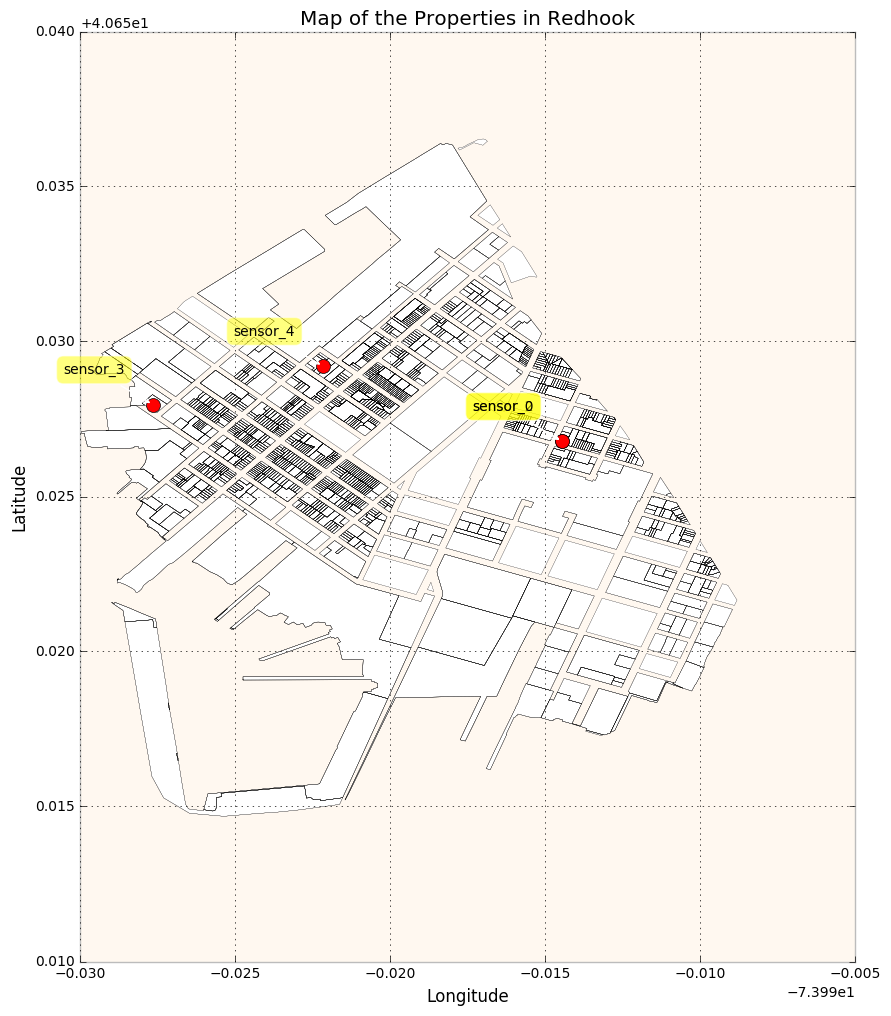

In [461]:
# Map of the Properties in Redhook
# The red dots represent the sensors location

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(10,12))

geoRedHook.plot(alpha=1,linewidth=0.1, ax=ax1, color='white')
NYCshape.plot(alpha=1,linewidth=0.1, ax=ax1, color='white')
gdfSensors.plot(marker='o', markersize=10, linewidth = 4, color = 'r', ax = ax1)
ax1.set_title('Map of the Properties in Redhook')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

for index, row in gdfSensors.iterrows():
    plt.annotate(
        row['sensor'],
        xy=(Point(row['geometry']).x, Point(row['geometry']).y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


#### Map I: Map of Redhook, the divisions represent PLUTO entries lots. The red dots indicate the location of the sensors (Sensors 2 and 0 share their latitude and longiture)

## Section II: Data Analysis

### II a) Features Correlations
##### We will analyze the different data from the sensors and try to meassure correlations between airpolution and other features (humidity and temperature)

In [399]:
# Create a list with the sensor names
# we will use it on the following helper functions

sensorsI = ["sensor_0","sensor_2","sensor_3","sensor_4"]

for i in range(4):
    print(sensors[sensorsI[i]]['data']["con"].std())

4246.89851076
756.411733577
722.436304499
2350.40821415


In [415]:
# Create a function to generate graphs displaying the pearson correlaitons
# Between air quality and other attributes

def generateSensorsPearsonsCorrelations (sensorsI, dependantName):

    # Create a title for the plot
    fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 0.1))
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_axis_bgcolor('black')
    ax1.set_title('Pearsons Cofficient meassures between ' + dependantName +\
                  ' and other features ', fontsize=15)
        
    fig, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, sharex='col', sharey='row', figsize=(16, 16))
    
    axs = [ax1, ax2, ax3, ax4]
    
    for i in range(4):        
        
        # Try to find correlations between the air quality 
        # and the different weather charactersitics

        corrTemp = (np.corrcoef(sensors[sensorsI[i]]['data']['hum'],\
                                    sensors[sensorsI[i]]['data']['con'])[0, 1])

        corrHum = (np.corrcoef(sensors[sensorsI[i]]['data']['temp'],\
                                    sensors[sensorsI[i]]['data']['con'])[0, 1])
                                                                         
        pearsons = {'Temperature': corrTemp, 'Humidity': corrHum}

        sorted_pearsons = sorted(pearsons.items(), key=operator.itemgetter(1))

        X = np.arange(len(pearsons))
        axs[i].bar(X, pearsons.values(), align='center', width=0.5)
        ind = np.arange(len(pearsons))
        width = 0.50
        xTickMarks = pearsons.keys()
        axs[i].set_xticks(ind)
        xtickNames = axs[i].set_xticklabels(xTickMarks)
        pl.setp(xtickNames, rotation=25, fontsize=10)
        ymax = max(pearsons.values())
        #axs[i].set_title('Correlation between Air Quality Rate and other features \n' , fontsize=14)

                                                                         # Set common labels
        # Set common labels
        fig.text(-0.01, 0.5, "Pearsons Coefficient", ha='center', va='center',
                 rotation='vertical', fontsize=16)
        
    pl.tight_layout()




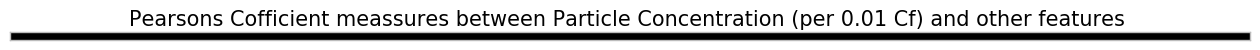

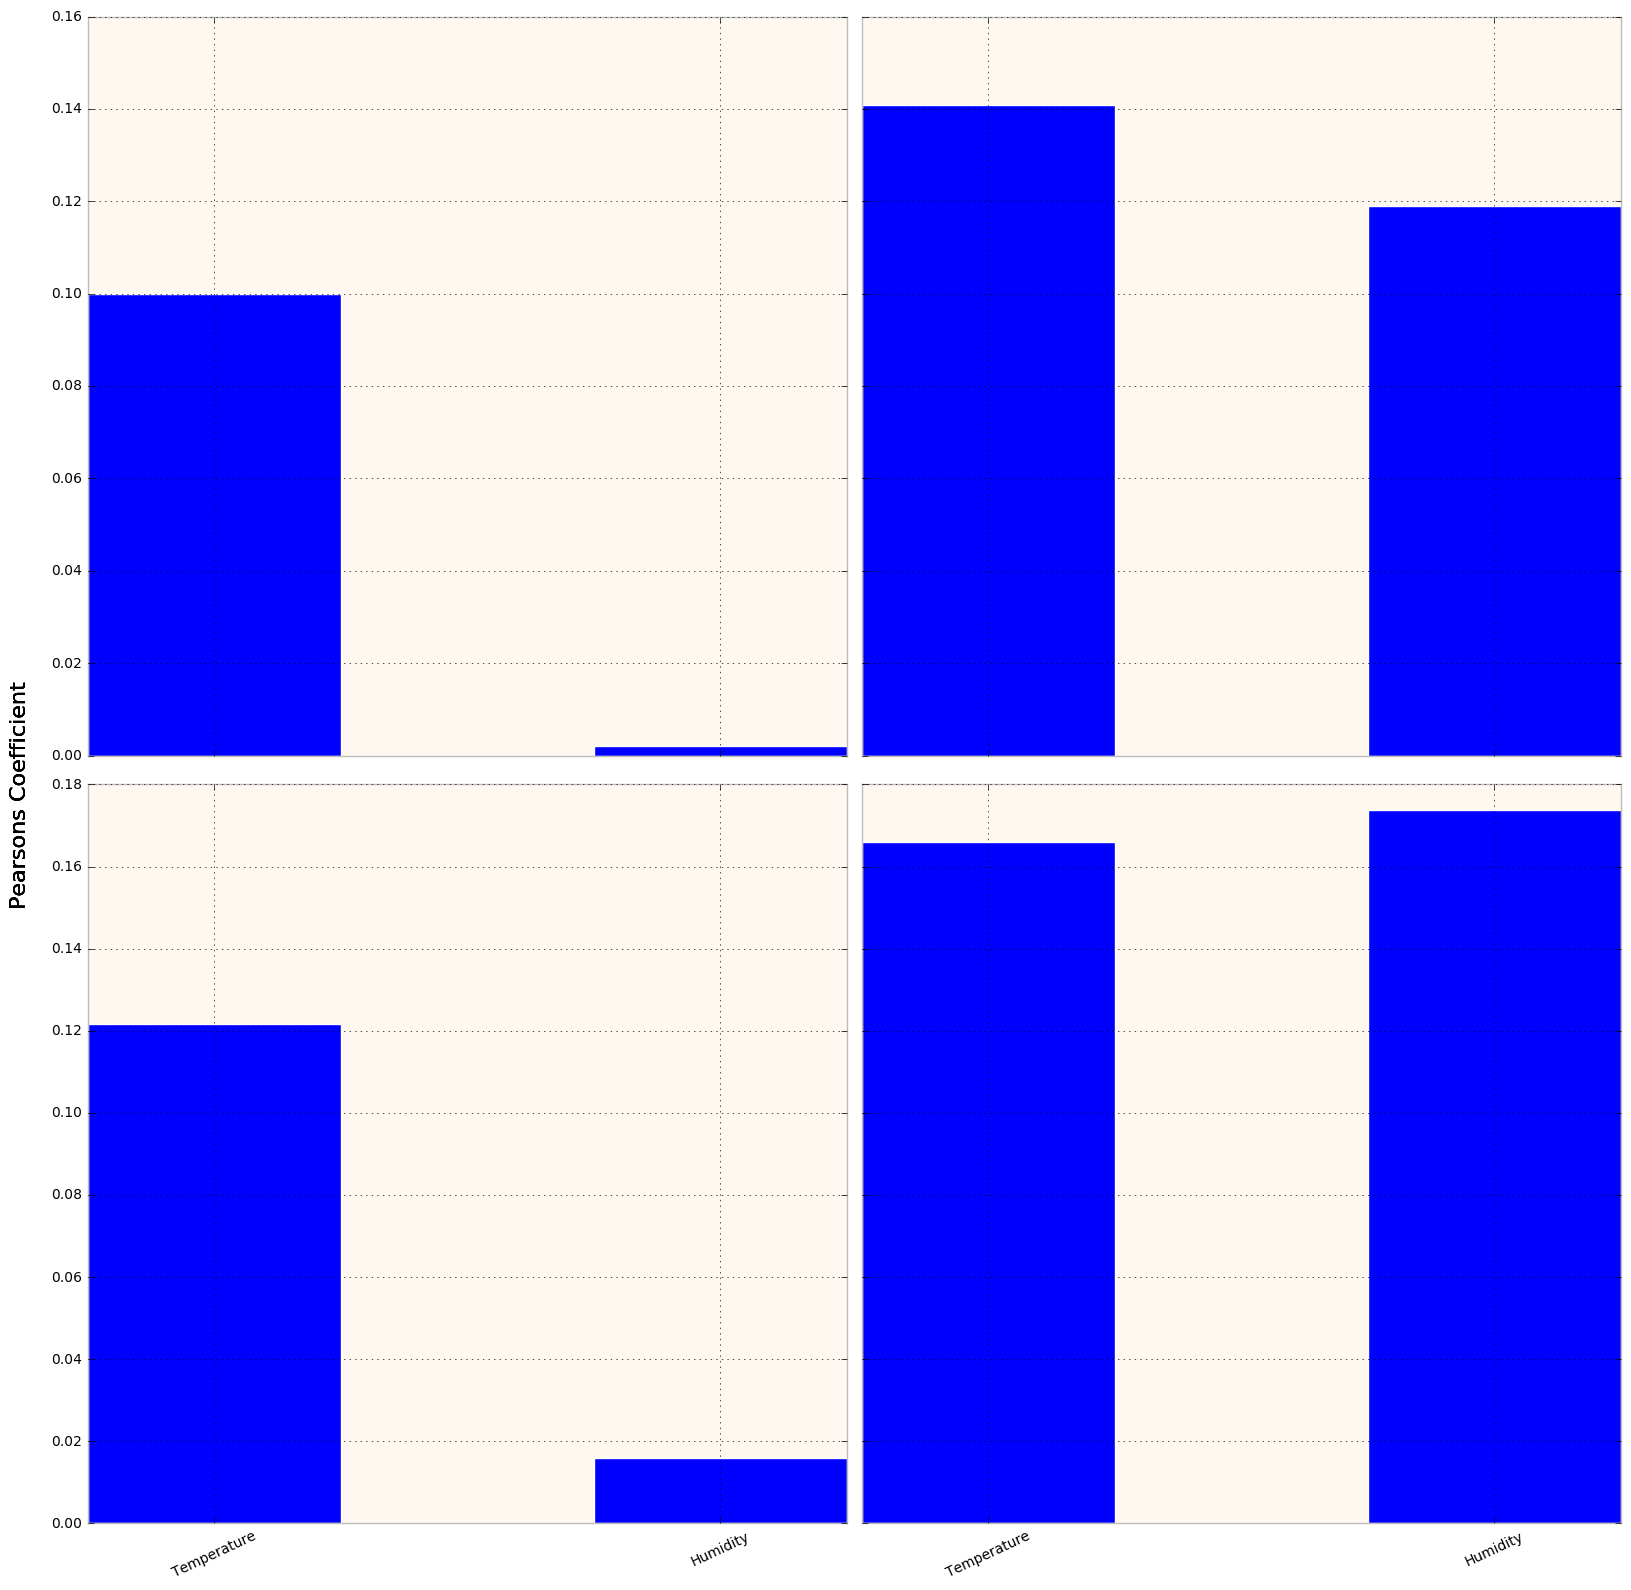

In [416]:
# Generate time series for event detection for particle 
generateSensorsPearsonsCorrelations(sensorsI,"Particle Concentration (per 0.01 Cf)")

### II b) Event detection
##### We will analyze the different data from the sensors and try to identify "events" (data points that are outside certain thereshold)

In [285]:
# Create a list with the sensor names
# we will use it on the following helper functions

sensorsI = ["sensor_0","sensor_2","sensor_3","sensor_4"]

for i in range(4):
    print(sensors[sensorsI[i]]['data']["con"].std())

4246.89851076
756.411733577
722.436304499
2350.40821415


In [390]:
def generateSensorsTimeSeriesAndOutliers (sensorsI, feature, featureName, t):
    
    # Create a title for the plot
    fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 0.1))
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_axis_bgcolor('black')
    ax1.set_title('Event detection for ' + featureName + ' using ' +
                  str (t) + " std as the thereshold", fontsize=15)
         
    fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(4, 1, sharex='col', sharey='row', figsize=(16, 16))
    
    axs = [ax1, ax2, ax3, ax4]
    
    for i in range(4):
        df = sensors[sensorsI[i]]['data']
        df.index = [df['dt']]
        
        df.head()
        
        # Define the threshold for event detection
        threshold = df[feature].std()*t
        
        df['rollingMean'] = rolling_median(df[feature], window=3,
                                   center=True).fillna(method='bfill').fillna(method='ffill')

        difference = np.abs(df[feature] - df['rollingMean'])
        outlier_idx = difference > threshold

        #fig, axs[i] = plt.subplots(figsize=(16, 4))
        df[feature].plot(ax=axs[i])
        kw = dict(marker='o', linestyle='none', color='r',
                  alpha=0.3, ax=axs[i])
        df[feature][outlier_idx].plot(**kw)


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).median()


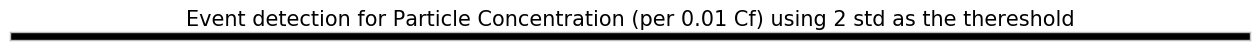

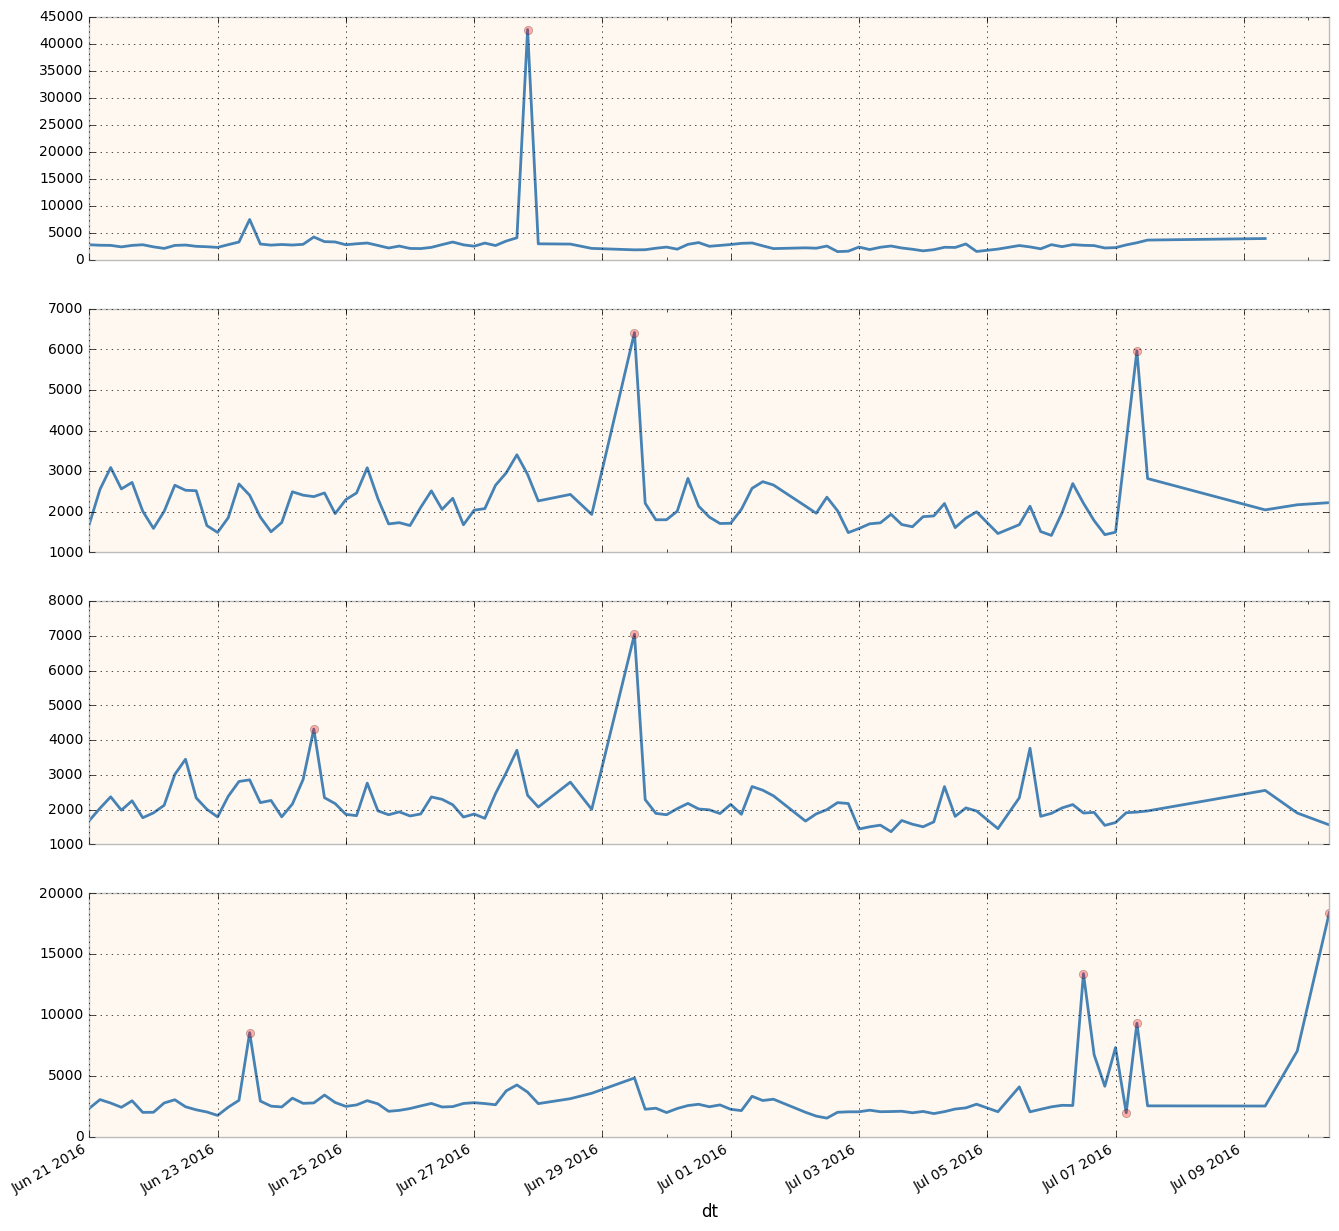

In [392]:
# Generate time series for event detection for particle 
df = generateSensorsTimeSeriesAndOutliers(sensorsI, "con",
                                             "Particle Concentration (per 0.01 Cf)", 2)


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).median()


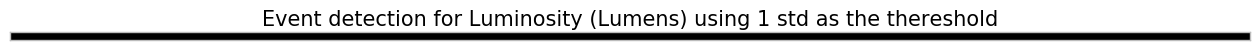

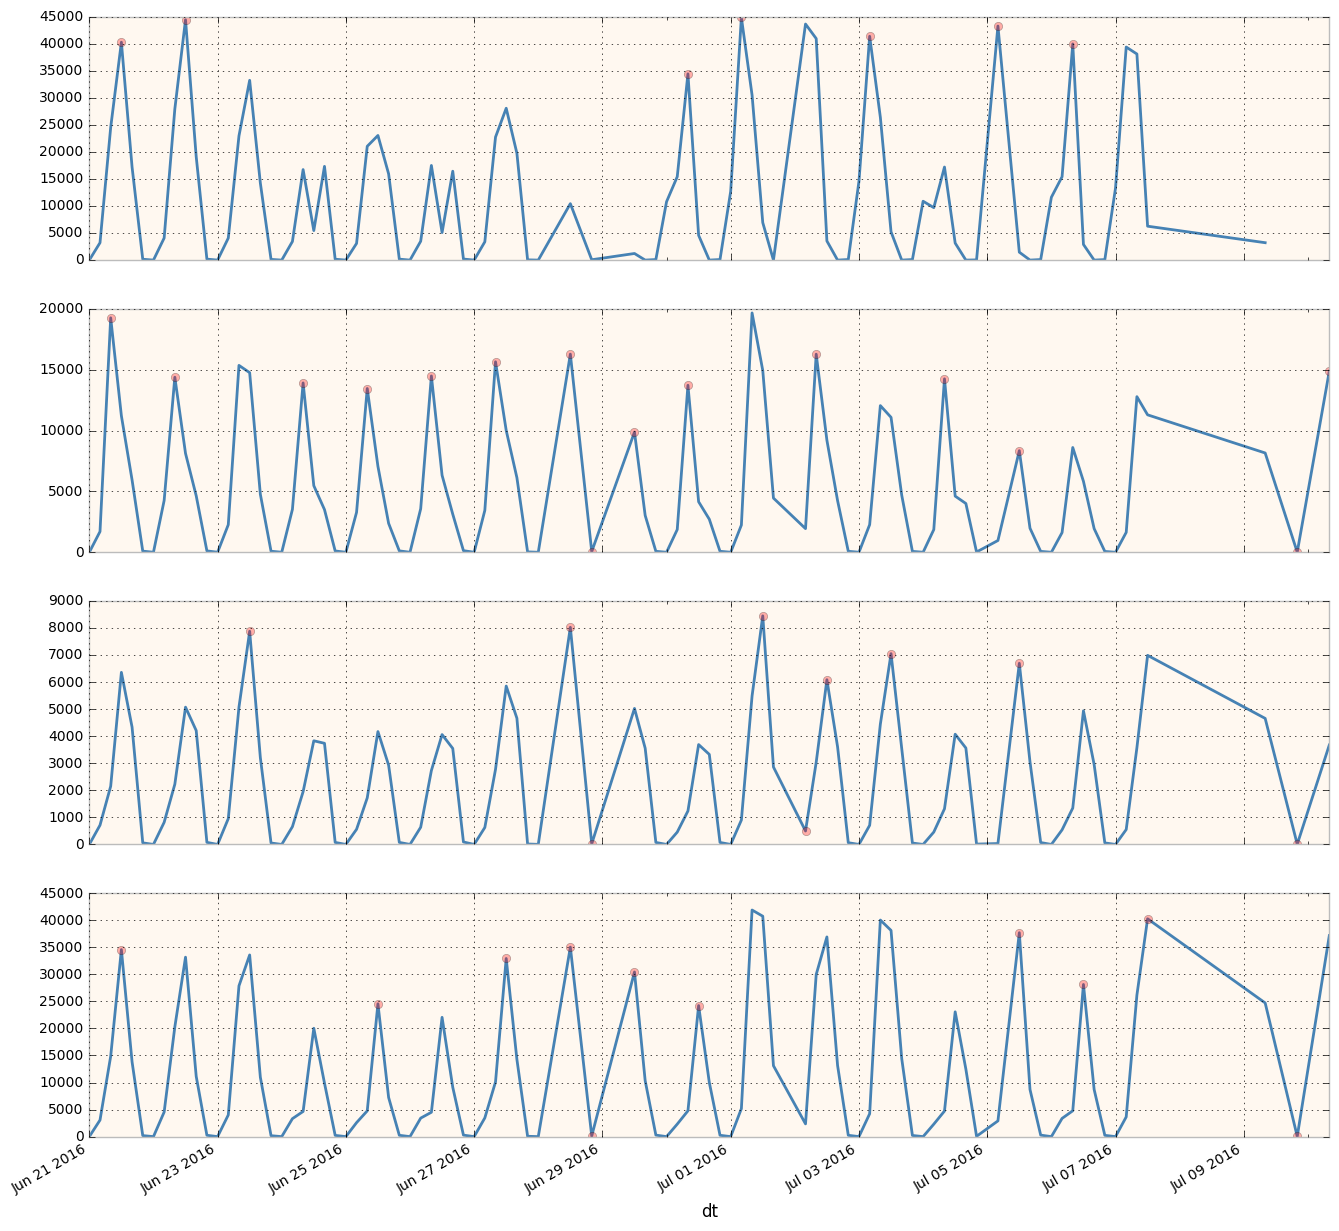

In [396]:
# Generate time series for event detection for particle 
df = generateSensorsTimeSeriesAndOutliers(sensorsI, "lux",
                                             "Luminosity (Lumens)", 1)


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).median()


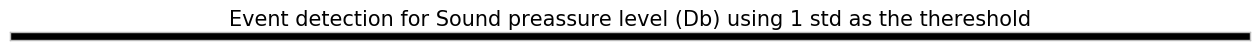

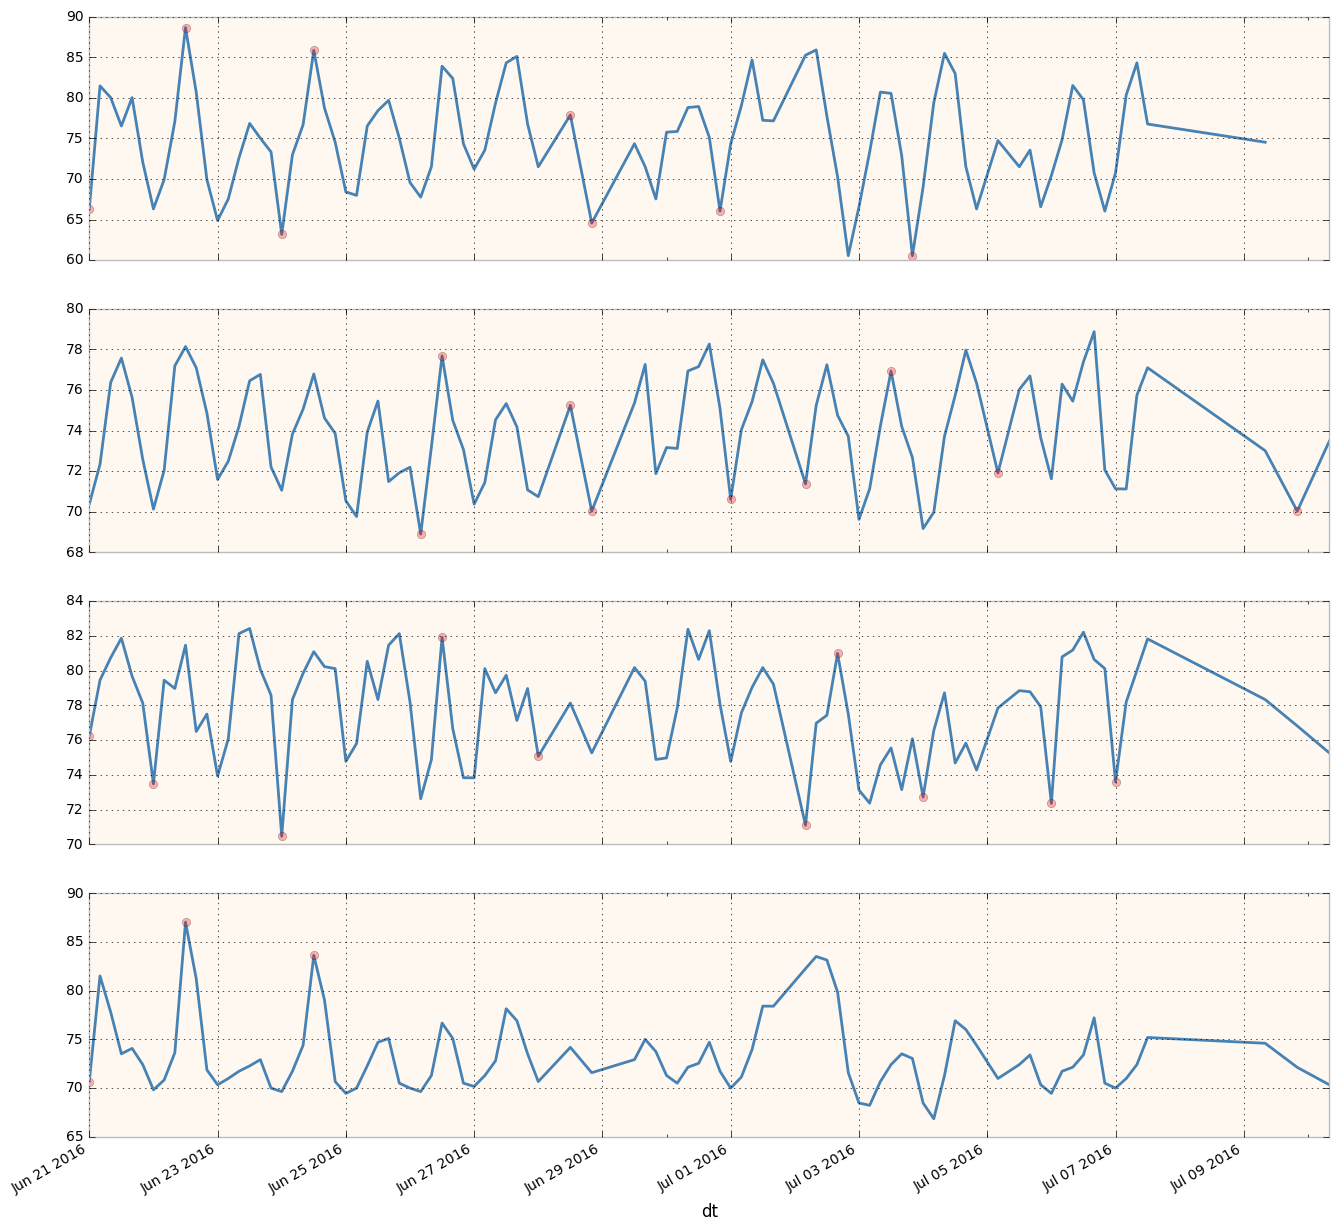

In [398]:
# Generate time series for event detection for particle 
df = generateSensorsTimeSeriesAndOutliers(sensorsI, "spl",
                                             "Sound preassure level (Db)", 1)

In [397]:
# Create a function to generate scatterplots and add regressions:

def generateSensorsPlotsAndRegressions (sensorsI, dependant, independant,
                                       dependantName, independantName):

    
    # Create a title for the plot
    fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 0.1))
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_axis_bgcolor('black')
    ax1.set_title('Relationship between ' + dependantName + ' and ' +
                  independantName, fontsize=15)
        
    fig, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, sharex='col', sharey='row', figsize=(16, 16))
    
    axs = [ax1, ax2, ax3, ax4]
    
    for i in range(4):
                
        axs[i].scatter(sensors[sensorsI[i]]['data'][independant],
               sensors[sensorsI[i]]['data'][dependant], s=20, alpha=0.3)

     
    
        # points linearlyd space on temperature from min to max , 100 points
        x = pd.DataFrame({independant: \
                          np.linspace(sensors[sensorsI[i]]['data'][independant].min(),
                                      sensors[sensorsI[i]]['data'][independant].max(), 100)})

        # 1-st order polynomial
        poly_1 = smf.ols(formula=dependant + ' ~ 1 + ' + independant, data=sensors[sensorsI[i]]['data']).fit()

        axs[i].plot(x[independant], poly_1.predict(x),
                'b-', label='Poly n=1 $\\bar R^2$=%.2f' % poly_1.rsquared_adj,
                alpha=0.9)

        # 2-nd order polynomial
        poly_2 = smf.ols(formula=dependant + ' ~ 1 + ' + independant + '\
        + I(' + independant + ' ** 2.0)', data=sensors[sensorsI[i]]['data']).fit()

        axs[i].plot(x[independant],
                poly_2.predict(x), 'g-', label='Poly n=2 $\\bar R^2$=%.2f' % poly_2.rsquared_adj,
                alpha=0.9)

        axs[i].legend()
        # Set common labels
        # Set common labels
        fig.text(0.5, -0.01, independantName, ha='center', va='center', fontsize=16)
        fig.text(-0.01, 0.5, dependantName, ha='center', va='center',
                 rotation='vertical', fontsize=16)
        pl.tight_layout()




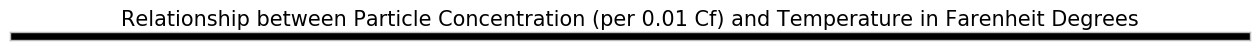

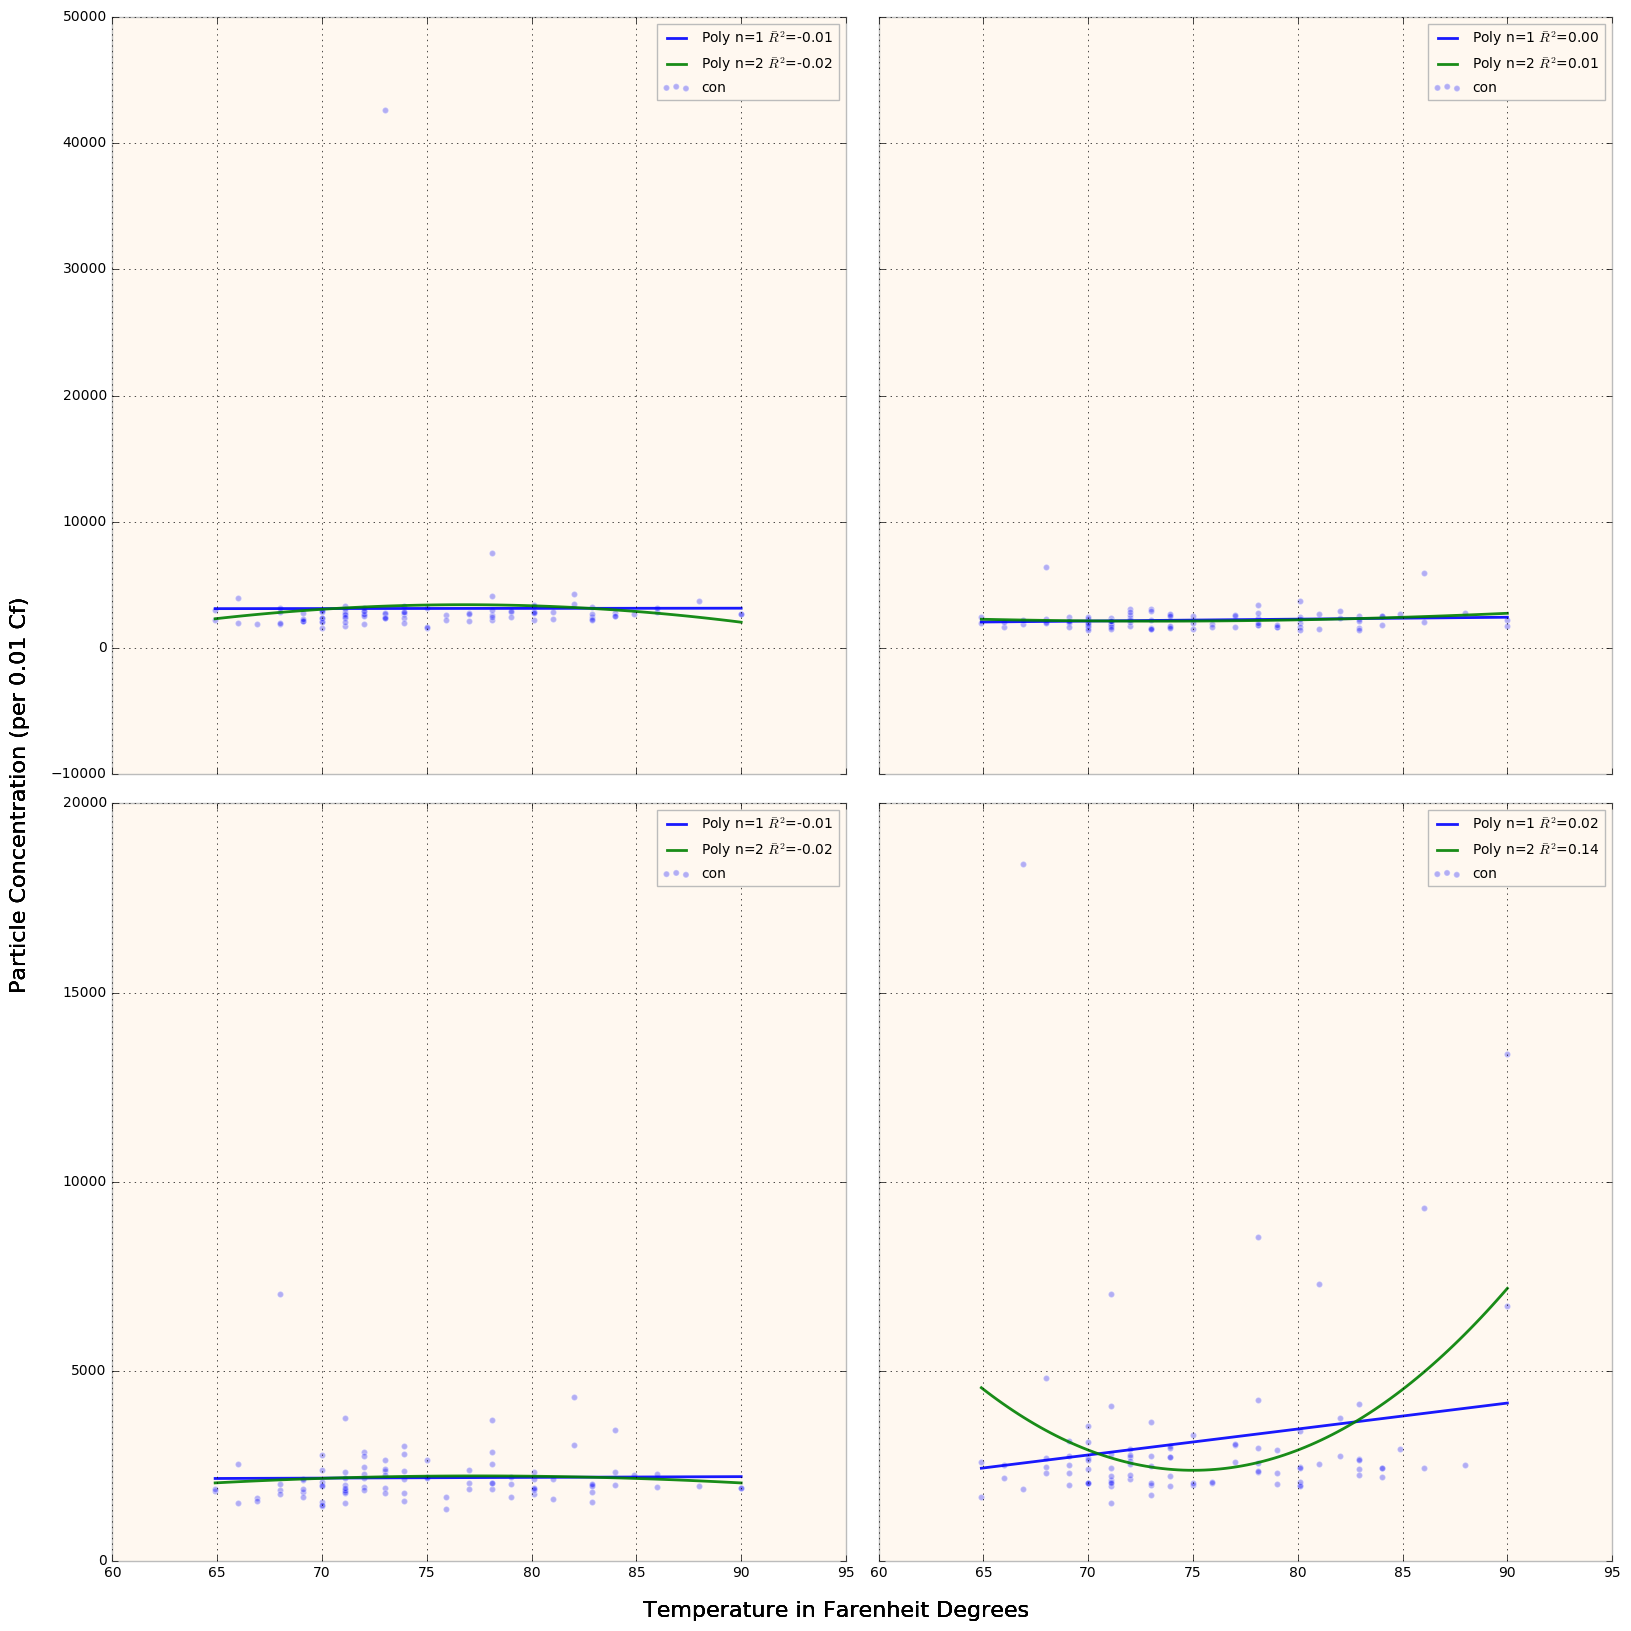

In [395]:
# Generate Scatterplots and regressions for Air QUality and Temperature

generateSensorsPlotsAndRegressions (sensorsI, "con", "temp", 
                                   "Particle Concentration (per 0.01 Cf)",
                                   "Temperature in Farenheit Degrees")

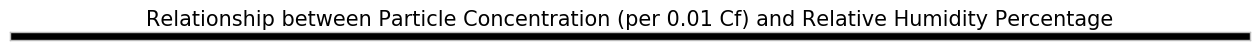

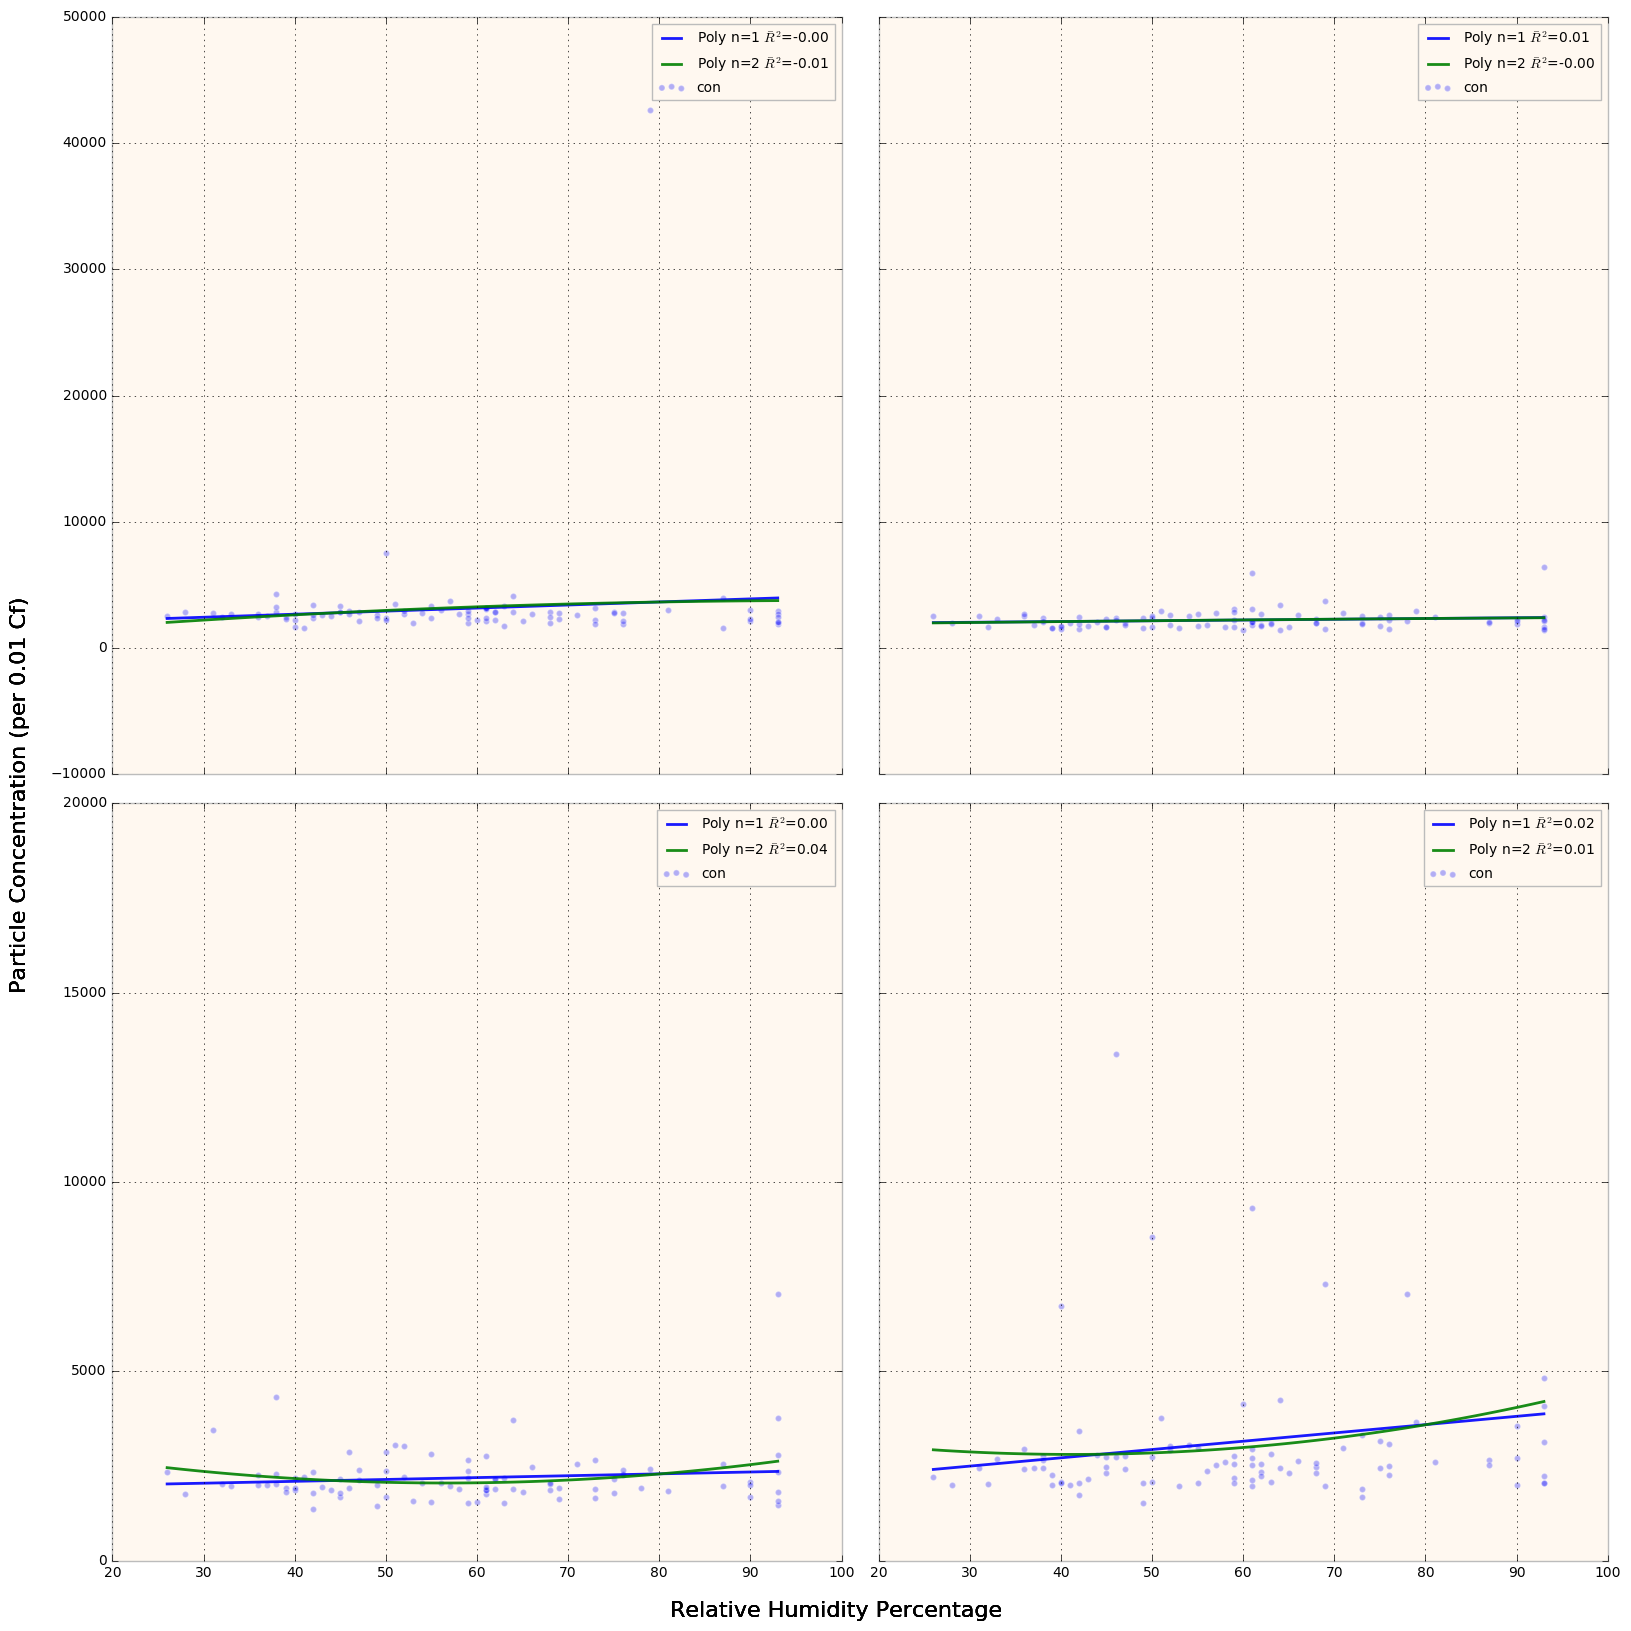

In [379]:
sensorsI = ["sensor_0","sensor_2","sensor_3","sensor_4"]
generateSensorsPlotsAndRegressions (sensorsI, "con", "hum",
                                   "Particle Concentration (per 0.01 Cf)",
                                   "Relative Humidity Percentage")